# Utilizing Observations to Create Application Characterization
Workflow:  
1. Gather Context starting with recording build options and run options
2. Decide on Important part(s) of Application to Analyze
3. Gather Observations with HPCToolkit
4. Perform Analysis

### Create Application Characterization from Observations
1. <a href=#Scaling>Scaling</a>  
2. <a href=#IPC>Instructions per Cycle</a>  
3. <a href=#MemoryBound>Memory Bound</a>  

---
### Using HPCToolkit
#### Build Application with Debug Symbols and Optimization Options
```
clang -g -O3 ...
```
#### To View Available Events:  
`hpcrun -L <.exe>`
![](assets/hpcrunList.png)

---

### Basic HPCToolkit Workflow
#### 1. Choose Desired Events and Measure
```
hpcrun -e <eventName1> -e <eventName2> ... -e <eventNameN> \
    -o MeasurementDirectory <.exe> [application options]
```
Repeat `hpcrun` as needed to collect all desired measurements.  
  
**Notes:**
1. *When collecting same measurement into same measurement directory it sums them into one value.*
2. *Measure Total Cycles carefully, counter can be effected by others*
    TODO: Figure out why exactly
3. *Total Cycles/CPUTIME is sum of all threads*
4. *Some events may conflict without proper error message*

#### 2. Build Binary Structure File
```
hpcstruct <.exe>
```
*Notes:*
1. *Only need to run hpcstruct once*

#### 3. Build HPCToolkit Database
```
hpcprof -S <.exe>.hpcstruct -I /Path/to/Src/'+' -o OutputDirectory MeasurementDirectory
```
*Notes:*   
1. *'+' Recursively Searches that Directory*  
2. *May include multiple `-I` arguments and multiple MeasurementDirectories*

#### 4. View HPCToolkit Database
```
hpcviewer OutputDirectory
```


---
<a name='Scaling'/></a>
# Scaling
### Gather Machine Information
`lstopo-no-graphics`  **or** `vim /proc/cpuinfo`  
Number of Cores: 18 Cores per Socket \* 2 Sockets = 36 Cores  
Number of Sockets: 2  
Number of Threads: 36 Cores \* 2 Threads per Core = 72 Threads (Hyperthreading)  
  
Understanding when hyperthreading starts (OMP affinity) ??? Multiple Sockets ???  
**At 36 Threads should be 1 Thread per core with default(scatter affinity)**


### Gather Time Measurements
Measure time for 1 thread. 
```
export OMP_NUM_THREADS=1
hpcrun -e CPUTIME -o TimeMeasurements/1Thread <.exe> [application options]
hpcstruct <.exe>
hpcprof -S <.exe>.hpcstruct -I /Path/to/Src -o outputDatabase TimeMeasurements/*
hpcviewer outputDatabase
```
1 Thread Time = 8.95e+07 usec * 1e+06 usec/sec =  __89.5 seconds__
  
**or**
```
export OMP_NUM_THREADS=1
time <.exe> [application options]
```
Repeat for different number of threads changing OMP_NUM_THREADS and **output name**

In [2]:
# Conversion Constant
USEC_per_SEC = 1e+6

# Map to hold measured exe time. Key = # of Threads
TIME = {}
TIME['1'] = 8.95e+07 / USEC_per_SEC
TIME['2'] = (9.13e+07 / 2) / USEC_per_SEC
TIME['4'] = (9.56e+07 / 4) / USEC_per_SEC
TIME['8'] = (1.25e+08 / 8) / USEC_per_SEC
TIME['18'] = (1.51e+08 / 18) / USEC_per_SEC
TIME['36'] = (1.68e+08 / 36) / USEC_per_SEC # 1 Thread per Core
TIME['72'] = (2.59e+08/ 72) / USEC_per_SEC # 2 Threads per Core

### Calculate Perfect Scaling Baseline

In [3]:
# Map to hold perfect scaling exe time
PerfectTIME = {}
# Calculate Perfect Scaling Baseline: Execution Time on 1 Thread / Number of Threads
for key in TIME.keys():
    PerfectTIME[key] = TIME['1'] / int(key)

### Compare Observed with Perfect

In [6]:
#imports for Graphing
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

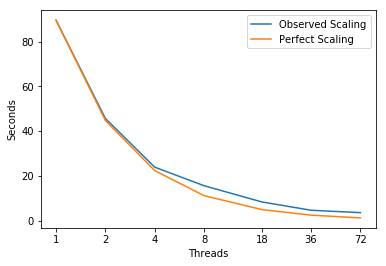

In [7]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads, list(TIME.values()), label='Observed Scaling')
ax.plot(Threads, list(PerfectTIME.values()), label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
<a name='IPC'/></a>
# Instructions per Cycle

### Gather Machine Information
Agner.org or Documentation
Maximum throughput for architecture pipeline = **4**  
  
*Notes:*
1. *Based on decoding 2 instructions per cycle with possibility of fused instructions*
2. *Instruction Microcache can hold decoded instructions*

**Two Instructions per Cycle per Core is more realistic baseline**

Observe Instructions per Cycle
```
hpcrun -e PAPI_TOT_CYC -e PAPI_TOT_INS \
       -o IPCMeasurements <.exe> [application options]
hpcstruct <.exe>
hpcprof -S <.exe>.hpcstruct -I /path/to/src -o IPCDatabase IPCMeasurements
hpcviewer IPCDatabase
```

In [9]:
Threads = 72
Cores = 36
Instructions_per_Cycle_per_Core_Baseline = 2
Total_Instructions = 3.61e+11
Total_Cycles = 6.51e+11 / Threads

Instructions_per_Cycle = Total_Instructions / Total_Cycles
Instructions_per_Cycle_Baseline = Instructions_per_Cycle_per_Core_Baseline * Cores
print('{:.4} Instructions per Cycle with {} IPC Baseline'.format(
    Instructions_per_Cycle, Instructions_per_Cycle_Baseline))
print('{:.2}% of Baseline'.format(Instructions_per_Cycle / Instructions_per_Cycle_Baseline))

39.93 Instructions per Cycle with 72 IPC Baseline
0.55% of Baseline


---
<a name='MemoryBound'/></a>
# Memory Bound 
---

## L1 Bandwidth

L1 Cache: L1 can do partial loads, cannot assume full cacheline. Look to see how many loads/cycle are being completed: `L1_Hit_Rate * LD_Instructions / Application_Cycles = L1_Loads_per_Cycle` vs. # Load Ports Available

### Gather Machine Information
Agner.org or Documetation  
**Number of Load Ports per Core = 2**

### Observe L1 Loads
```
hpcrun -e PAPI_L1_DCM -e PAPI_LD_INS -e PAPI_SR_INS \
       -o L1LoadMeasurments <.exe> [application options]
hpcstruct <.exe>
hpcprof -S <.exe>.hpcstruct -I /path/to/src -o L1LoadDatabase measurementDirectory
hpcviewer L1LoadDatabase
```
### Calculate L1 Loads per Cycle


In [16]:
# Machine Information
Threads = 72
Cores = 36
Load_Ports_per_Core = 2
Total_Load_Ports = Load_Ports_per_Core * Cores

# Measurements from HPCToolkit
PAPI_LD_INS = 1.19e+10
PAPI_SR_INS = 6.34e+10
PAPI_L1_DCM = 1.00e+10

# Analysis
L1_Miss_Rate = PAPI_L1_DCM / (PAPI_LD_INS + PAPI_SR_INS)
L1_Loads = PAPI_LD_INS * L1_Miss_Rate
L1_Loads_per_Cycle = L1_Loads / Total_Cycles # From IPC Measurements
print('L1 Data Cache Miss Rate: {:.2}%'.format(L1_Miss_Rate))
print('{:.3} Loads per Cycle with {} Load Ports'.format(L1_Loads_per_Cycle, Total_Load_Ports))
print('{:.3} Loads per Cycle per Core'.format(L1_Loads_per_Cycle/ Total_Load_Ports))

L1 Data Cache Miss Rate: 0.13%
0.175 Loads per Cycle with 72 Load Ports
0.00243 Loads per Cycle per Core


---
## Memory Bandwidth beyond L1 Cache

1. <a href=#Roofline>Measure system with Empirical Roofline Toolkit</a>
2. <a href=#HPCToolkit>Measure application with HPCToolkit</a>
3. <a href=#Analyze>Analyze the data</a>

<a name='Roofline'/></a>
### 1. Measure the System with Empirical Roofline ToolKit
```
git clone https://bitbucket.org/berkeleylab/cs-roofline-toolkit.git
cd cs-roofline-toolkit/Empirical_Roofline_Tool-1.1.0
```
// TODO: Edit/Rename existing config file in Config directory // Explain some values or point to ERT Doc?  
```
./ert /Path/to/your/config.file
```
View the .ps file in the results directory
![](assets/roofline.png)
Extract the Data

In [163]:
# Data From Roofline
Roofline_Bandwidth = {}
Roofline_Bandwidth['L1'] = 2399.9 # GB/s
Roofline_Bandwidth['L2']  = 784.0 # GB/s
Roofline_Bandwidth['L3']  = 564.8 # GB/s
Roofline_Bandwidth['DRAM']  = 60.4 # GB/s

#### Collect Additional System Data

In [164]:
# Collect information from other sources
BYTES_per_CACHELINE = 64 # Bytes per Cacheline # From Documentation
CPU_MHz = 2301.0 # MHz # From lscpu or /proc/cpuinfo

<a name='HPCToolkit'/></a>
### 2. Measure the Application with HPCToolkit
#### Choose Desired Events and Measure
```
hpcrun -e PAPI_L1_DCM -e PAPI_L2_DCM -e PAPI_L2_ICM -e PAPI_L3_TCM \
    -o BWMeasurements <.exe> [application options]
hpcrun -e PAPI_TOT_CYC -e PAPI_LD_INS -e PAPI_SR_INS \
    -o BWMeasurements <.exe>
hpcstruct <.exe>
hpcprof -S <.exe>.hpcstruct -I /Path/to/Src/'+' -o BWDatabase BWMeasurements
hpcviewer BWDatabase
```

<a name='Analyze'/></a>
### 3. Analyze the Data

In [171]:
# Measurements from HPCToolkit

# TODO: Discuss the various ways to count this?
BW_Used = {}
BW_Used['L2'] = L1_misses = 1.52e+10 # Cachelines
BW_Used['L3'] = L2_misses = 1.06e+10 # Cachelines
BW_Used['DRAM'] = L3_misses = 1.04e+09 # Cachelines # L3 Misses = L3_TCM - L2_ICM

Total_Cycles = 1.42e+12 # cycles

Threads = 72

In [168]:
# Conversion Constants
BYTES_per_GB = 1073741824
CYCLES_per_SEC_per_MHz = 1000000

In [167]:
# Do Some Conversions

# Measured Cycles to Seconds
CYCLES_per_SEC = CPU_MHz * CYCLES_per_SEC_per_MHz
Application_Run_Cycles = Total_Cycles / Threads # Total Cycles counted on each thread
Application_Seconds = Application_Run_Cycles / CYCLES_per_SEC

# Convert HPCToolkit Measurement to GB/sec
# Cachelines to Bytes to GBs / Cycles to sec
for CacheName, Cachelines in BW_Used.items():
    Bytes_Used = Cachelines * BYTES_per_CACHELINE # Bytes
    GB_Used = Bytes_Used / BYTES_per_GB # GBs
    Application_BW = GB_Used / Application_Seconds # GB/sec

    # Compare with roofline results
    Utilization = Application_BW / Roofline_Bandwidth[CacheName]
    print('{} Bandwidth Used: {:.2f}%'.format(CacheName, Utilization * 100))

L2 Bandwidth Used: 13.48%
L3 Bandwidth Used: 13.05%
DRAM Bandwidth Used: 11.97%


If bandwidth utilization is low, but application is bound on memory then most likely bound by memory latency.